In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scienceplots
from scipy.interpolate import interp1d
from scipy.differentiate import derivative
from scipy.optimize import root_scalar

In [3]:
data = pd.read_csv('mt_boson_list.csv', header=None)
data.iloc[:, 1] = data.iloc[:, 1].astype(str).str.replace(r'\*\^', 'e', regex=True).astype(float)

plt.style.use(['science'])
x = data.iloc[:,0]
y = data.iloc[:,1]

## Normal PSPL lightcurve

In [4]:
u_min = 1
t_E = 1

def impact_par(t):
    return np.sqrt(u_min**2 + t**2/t_E**2)

def pspl_magnification(t):
    u = impact_par(t)
    return (u**2 + 2) / (u*np.sqrt(u**2 + 4))


<function matplotlib.pyplot.show(close=None, block=None)>

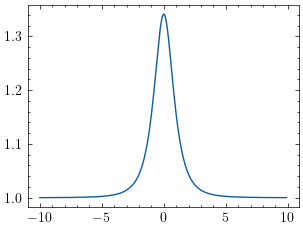

In [5]:
timestamps = np.arange(-10,10,0.1)

plt.plot(timestamps, pspl_magnification(timestamps))
plt.show


## PL microlens embedded in a macrolens
### Analytic solution

In [6]:
mu_r = 3
mu_t = 100

def tau_pl_pos(t):
    u = impact_par(t)
    return (mu_r/2)*u + np.sqrt((u**2)*(mu_r/2)**2 + mu_r)

def tau_pl_neg(t):
    u = impact_par(t)
    return (mu_r/2)*u - np.sqrt((u**2)*(mu_r/2)**2 + mu_r)

def pl_embedded_magnification_inv(tau):
    return (1/mu_r)*(1/mu_t) - ((1/mu_r)-(1/mu_t))*(1/tau**2) - (1/tau**4)

def pl_total_mag(t):
    return (1/np.abs(pl_embedded_magnification_inv(tau_pl_pos(t))) 
            + 1/np.abs(pl_embedded_magnification_inv(tau_pl_neg(t))))

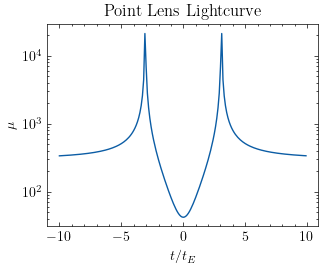

In [80]:
plt.plot(timestamps, pl_total_mag(timestamps))
plt.xlabel(r'$t/t_E$')
plt.ylabel(r'$\mu$')
plt.yscale('log')
plt.title(r'Point Lens Lightcurve')
plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/pl_lightcurve.png', dpi=300, format='png')

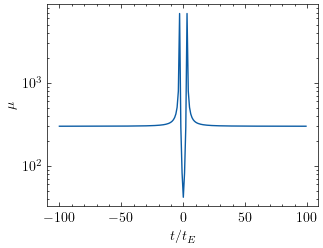

In [8]:
timestamps_closer_look = np.arange(-100,100,1)
plt.plot(timestamps_closer_look, pl_total_mag(timestamps_closer_look))
plt.xlabel(r'$t/t_E$')
plt.ylabel(r'$\mu$')
plt.yscale('log')

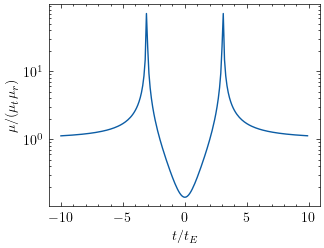

In [9]:
def relative_mag(t):
    return pl_total_mag(t)/(mu_t*mu_r)

plt.plot(timestamps,relative_mag(timestamps))
plt.xlabel(r'$t/t_E$')
plt.ylabel(r'$\mu/(\mu_{t}\mu_{r})$')
plt.yscale('log')

### Numerical solution (test)

In [62]:
def pl_lens_eqn(tau,t):
    return (tau / mu_r) - (1/tau) - impact_par(t)

all_solutions_pl = []

for t in timestamps:

    pl_tau_values_pos = np.linspace(0.001, 100, 10000)

    pl_lens_eqn_vals_pos = pl_lens_eqn(pl_tau_values_pos, t)

    pl_roots_pos = []

    for i in range(len(pl_tau_values_pos) - 1):
        if pl_lens_eqn_vals_pos[i] * pl_lens_eqn_vals_pos[i+1] < 0:
            a, b = pl_tau_values_pos[i], pl_tau_values_pos[i+1]
            sol = root_scalar(pl_lens_eqn, args=(t,), bracket=[a, b], method='brentq')
            if sol.converged:
                pl_roots_pos.append(sol.root)

    pl_tau_values_neg = np.linspace(-100, -0.001, 10000)

    pl_lens_eqn_vals_neg = pl_lens_eqn(pl_tau_values_neg, t)

    pl_roots_neg= []

    for i in range(len(pl_tau_values_neg) - 1):
        if pl_lens_eqn_vals_neg[i] * pl_lens_eqn_vals_neg[i+1] < 0:
            a, b = pl_tau_values_neg[i], pl_tau_values_neg[i+1]
            sol = root_scalar(pl_lens_eqn, args=(t,), bracket=[a, b], method='brentq')
            if sol.converged:
                pl_roots_neg.append(sol.root)

    all_solutions_pl.append((pl_roots_pos, pl_roots_neg)) 

all_solutions_pl

[([30.24880433717485], [-0.09917747381218357]),
 ([29.951293251704254], [-0.10016261985045666]),
 ([29.653832217180973], [-0.10116736272156011]),
 ([29.35642275101536], [-0.10219228771312891]),
 ([29.059066432262544], [-0.10323800342977998]),
 ([28.761764904768167], [-0.10430514295398555]),
 ([28.46451988050757], [-0.10539436507610553]),
 ([28.167333143132623], [-0.10650635559836669]),
 ([27.870206551741067], [-0.10764182871879954]),
 ([27.573142044884857], [-0.10880152849887322]),
 ([27.276141644835292], [-0.10998623042302788]),
 ([26.97920746212413], [-0.11119674305523954]),
 ([26.682341700381688], [-0.11243390980024404]),
 ([26.38554666149459], [-0.11369861077686697]),
 ([26.088824751108014], [-0.11499176481199293]),
 ([25.792178484499395], [-0.11631433156384997]),
 ([25.495610492852833], [-0.11766731378489713]),
 ([25.199123529966375], [-0.11905175973412148]),
 ([24.90272047942713], [-0.12046876575105069]),
 ([24.606404362292363], [-0.12191947900349456]),
 ([24.31017834531846], [-0

Text(0.5, 1.0, 'Point Lens Lightcurve')

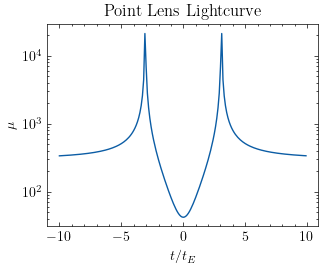

In [77]:
magnifications_pl = []

for i in all_solutions_pl:
    mag_temp = []
    if len(i[0]) > 0:
        for j in i[0]:
            mag_temp.append(1/np.abs(pl_embedded_magnification_inv(j)))
    if len(i[1]) > 0:
        for j in i[1]:
            mag_temp.append(1/np.abs(pl_embedded_magnification_inv(j)))
    total_mag = np.sum(mag_temp)
    magnifications_pl.append(total_mag)

plt.plot(timestamps, magnifications_pl)
plt.xlabel(r'$t/t_E$')
plt.ylabel(r'$\mu$')
plt.yscale('log')
plt.title(r'Point Lens Lightcurve')

## Boson star embedded in macro lens

In [53]:
def m(mtau,tau_m=1.0): #mtau Pandas DataFrame, tau_m consant
    mtau_cop = mtau.copy()
    mtau_cop.iloc[:,0] = tau_m * mtau_cop.iloc[:,0]
    mtau_interp = interp1d(mtau_cop.iloc[:,0], mtau_cop.iloc[:,1], kind='cubic', fill_value='extrapolate')
    return mtau_interp

def m_prime(m,tau):
    return derivative(m, tau, maxiter=2, order=3)

def inverse_magnification(m,tau):
    return (
        ((1/mu_r - (m_prime(m,tau).df / (2.0 * tau)) ) * (1/mu_t - (m_prime(m,tau).df / (2.0 * tau)) )) -
        ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))**2 +
        (1/mu_r - 1/mu_t) * ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))
    )

In [105]:
m_tau = m(data,20)

def lens_eqn(tau, t):
    return (tau / mu_r) - (m_tau(tau) / tau) - impact_par(t)

tau_values_pos = np.linspace(0.001, 100, 10000)

tau_values_neg = np.linspace(-100, -0.001, 10000)


In [106]:
all_solutions = []

for t in timestamps: 

    lens_eqn_vals_pos = [lens_eqn(tau, t) for tau in tau_values_pos]
    lens_eqn_vals_neg = [lens_eqn(tau, t) for tau in tau_values_neg]
    roots_pos = []
    roots_neg = []

    for i in range(len(tau_values_pos) - 1):
        if lens_eqn_vals_pos[i] * lens_eqn_vals_pos[i+1] < 0:
            a, b = tau_values_pos[i], tau_values_pos[i+1]
            sol = root_scalar(lens_eqn, args=(t,), bracket=[a, b], method='brentq')
            if sol.converged:
                roots_pos.append(sol.root)
            
    for i in range(len(tau_values_neg) - 1):
        if lens_eqn_vals_neg[i] * lens_eqn_vals_neg[i+1] < 0:
            a, b = tau_values_neg[i], tau_values_neg[i+1]
            sol = root_scalar(lens_eqn, args=(t,), bracket=[a, b], method='brentq')
            if sol.converged:
                roots_neg.append(sol.root)

    all_solutions.append((roots_pos, roots_neg)) 

all_solutions 

[([30.248758891397856], []),
 ([29.9512411234108], []),
 ([29.65377260794325], []),
 ([29.356354857526373], []),
 ([29.058989268022255], []),
 ([28.761677206800197], []),
 ([28.46442020075625], []),
 ([28.167219946590034], []),
 ([27.870078214236234], []),
 ([27.572996843163256], []),
 ([27.275977663615357], []),
 ([26.979022333887368], []),
 ([26.682132602708517], []),
 ([26.385310545216047], []),
 ([26.088558389997033], []),
 ([25.791878453069835], []),
 ([25.495273070205073], []),
 ([25.198744246161873], []),
 ([24.902293980987398], []),
 ([24.605924597208084], []),
 ([24.309638745243998], []),
 ([24.01343979417497], []),
 ([23.717330937390006], []),
 ([23.42131408451981], []),
 ([23.12539130696442], []),
 ([22.829565430221805], []),
 ([22.533840037367526], []),
 ([22.238219403616704], []),
 ([21.942706782599014], []),
 ([21.64730483136568], []),
 ([21.35201646417441], []),
 ([21.056844668106304], []),
 ([20.761792518832006], []),
 ([20.46686551940774], []),
 ([20.17207000623549], [

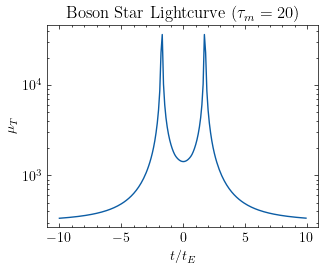

In [107]:
magnifications = []

for i in all_solutions:
    magn_temp = []
    if len(i[0]) > 0:
        for j in i[0]:
            magn_temp.append(1/np.abs(inverse_magnification(m_tau,j)))
    if len(i[1]) > 0:
        for j in i[1]:
            magn_temp.append(1/np.abs(inverse_magnification(m_tau,j)))
    total_magn = np.sum(magn_temp)
    magnifications.append(total_magn)

plt.plot(timestamps, magnifications)
plt.xlabel(r'$t/t_E$')
plt.ylabel(r'$\mu_T$')
plt.yscale('log')
plt.title(r'Boson Star Lightcurve $(\tau_m =20)$')
#plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/boson_star_lightcurve_tm=10.png', dpi=300, format='png')

magnifications_tm_20 = magnifications.copy()

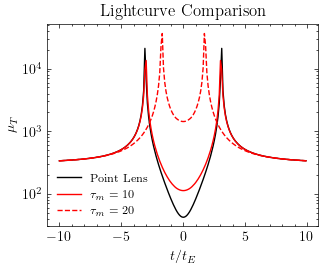

In [118]:
plt.plot(timestamps, magnifications_pl, color = 'black', label = 'Point Lens')
plt.plot(timestamps, magnifications_tm_10, color = 'red', label=r'$\tau_m = 10$')
plt.plot(timestamps, magnifications_tm_20, color = 'red', linestyle = '--', label=r'$\tau_m = 20$')
plt.xlabel(r'$t/t_E$')
plt.ylabel(r'$\mu_T$')
plt.legend(loc='lower left', fontsize ='small')
plt.yscale('log')
plt.title(r'Lightcurve Comparison')
plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/lightcurve_comparison.png', dpi=300, format='png')
